
# Project 3: E‑Commerce Transactions Analysis (Final)

This is the **final, streamlined notebook** for Project 3.  
Run top-to-bottom to: **load → clean → KPIs → EDA → export** (CSVs & PNGs).

**Expected dataset:** `../data/ecommerce_transactions.csv`  
**Outputs saved to:** `../data/` (CSVs) and `../powerbi/` (PNGs)


In [1]:

# === CONFIG ===
DATA_PATH = "../data/ecommerce_transactions.csv"
CLEAN_OUT = "../data/ecommerce_transactions_clean.csv"
MONTHLY_OUT = "../data/monthly_revenue_rollup.csv"
CAT_OUT = "../data/category_revenue_rollup.csv"
REGION_OUT = "../data/region_revenue_rollup.csv"
PAYMENT_OUT = "../data/payment_revenue_rollup.csv"
TOPCUSTOMERS_OUT = "../data/top_customers_rollup.csv"

# column names (update here if your schema changes)
DATE_COL  = "Transaction_Date"
REV_COL   = "Purchase_Amount"
CUST_COL  = "User_Name"
PROD_COL  = "Product_Category"
REG_COL   = "Country"
ID_COL    = "Transaction_ID"
PAYMENT_COL = "Payment_Method"

# === IMPORTS & STYLE ===
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

# ensure output folders exist
Path("../powerbi").mkdir(parents=True, exist_ok=True)


## 1) Load, Clean, and Feature Engineer

In [2]:

# Load
df = pd.read_csv(DATA_PATH)

# Basic clean / dtypes
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df[REV_COL]  = pd.to_numeric(df[REV_COL], errors="coerce")

# Derived time columns
df["Order_Year"]  = df[DATE_COL].dt.year
df["Order_Month"] = df[DATE_COL].dt.to_period("M").astype(str)
df["Order_Date"]  = df[DATE_COL].dt.date

# Hygiene
before = len(df)
df = df.drop_duplicates()
invalid_dates = df[DATE_COL].isna().sum()

print(f"Loaded {before:,} rows → {len(df):,} after de-duplication.")
print("Rows with invalid dates:", invalid_dates)
display(df.head(3))


Loaded 50,000 rows → 50,000 after de-duplication.
Rows with invalid dates: 0


,Transaction_ID,User_Name,Age,Country,Product_Category,Purchase_Amount,Payment_Method,Transaction_Date,Order_Year,Order_Month,Order_Date
0,1,Ava Hall,63,Mexico,Clothing,780.69,Debit Card,2023-04-14,2023,2023-04,2023-04-14
1,2,Sophia Hall,59,India,Beauty,738.56,PayPal,2023-07-30,2023,2023-07,2023-07-30
2,3,Elijah Thompson,26,France,Books,178.34,Credit Card,2023-09-17,2023,2023-09,2023-09-17


## 2) KPI Snapshot

In [3]:

kpis = pd.DataFrame({
    "Total Revenue": [df[REV_COL].sum()],
    "Transactions": [df[ID_COL].nunique()],
    "Unique Customers": [df[CUST_COL].nunique()],
    "Avg Order Value (AOV)": [df[REV_COL].mean()]
}).T.rename(columns={0: "Value"})
kpis


,Value
Total Revenue,"25,157,989.65"
Transactions,"50,000.00"
Unique Customers,100.00
Avg Order Value (AOV),503.16


In [4]:

def titleify(ax, title):
    ax.set_title(title)
    ax.set_xlabel("")
    plt.tight_layout()

def save_fig(path):
    plt.savefig(path, dpi=180, bbox_inches="tight")
    print("Saved chart →", path)


## 3) EDA

### 3.1 Monthly Revenue Trend

,Order_Month,Total_Revenue,Transactions,Unique_Customers,Month_dt,Revenue_MoM_%
0,2023-03,"802,390.44",1560,100,2023-03-01,NaN
1,2023-04,"1,046,921.48",2049,100,2023-04-01,30.48
2,2023-05,"1,050,553.40",2092,100,2023-05-01,0.35
3,2023-06,"1,011,635.06",2029,100,2023-06-01,-3.70
4,2023-07,"1,105,402.88",2154,100,2023-07-01,9.27


Saved table → ../data/monthly_revenue_rollup.csv
Saved chart → ../powerbi/monthly_revenue_trend.png


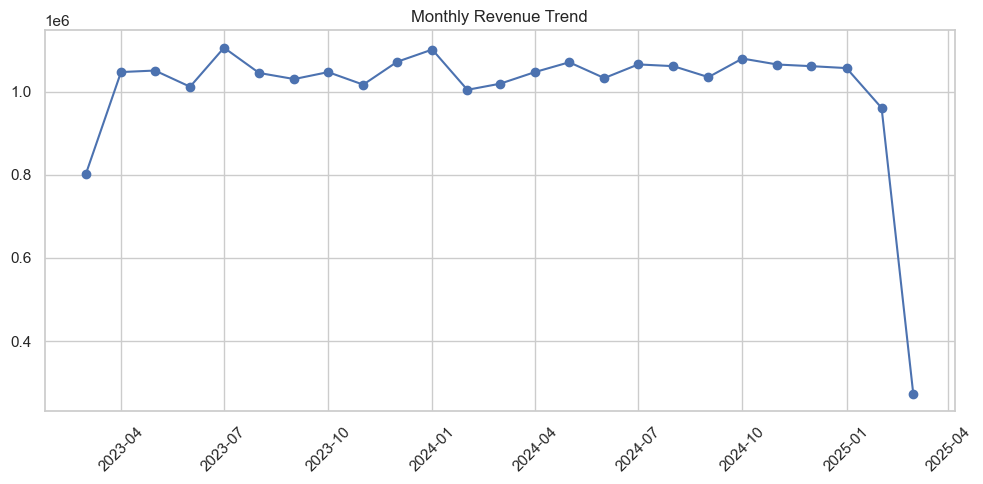

In [5]:

monthly = (df.groupby("Order_Month", as_index=False)
             .agg(Total_Revenue=(REV_COL,"sum"),
                  Transactions=(ID_COL,"count"),
                  Unique_Customers=(CUST_COL,"nunique")))
monthly["Month_dt"] = pd.to_datetime(monthly["Order_Month"] + "-01")
monthly = monthly.sort_values("Month_dt")
monthly["Revenue_MoM_%"] = monthly["Total_Revenue"].pct_change() * 100
display(monthly.head())

monthly.to_csv(MONTHLY_OUT, index=False)
print("Saved table →", MONTHLY_OUT)

fig, ax = plt.subplots()
ax.plot(monthly["Month_dt"], monthly["Total_Revenue"], marker="o")
ax.tick_params(axis="x", rotation=45)
titleify(ax, "Monthly Revenue Trend")
save_fig("../powerbi/monthly_revenue_trend.png")
plt.show()


### 3.2 Top Product Categories

,Product_Category,Total_Revenue,Transactions,Unique_Customers
6,Sports,"3,195,335.90",6312,100
7,Toys,"3,185,652.36",6392,100
1,Books,"3,181,897.30",6253,100
2,Clothing,"3,171,225.96",6224,100
3,Electronics,"3,133,965.04",6320,100
4,Grocery,"3,123,579.52",6215,100
5,Home & Kitchen,"3,108,945.78",6209,100
0,Beauty,"3,057,387.79",6075,100


Saved table → ../data/category_revenue_rollup.csv
Saved chart → ../powerbi/top_categories.png


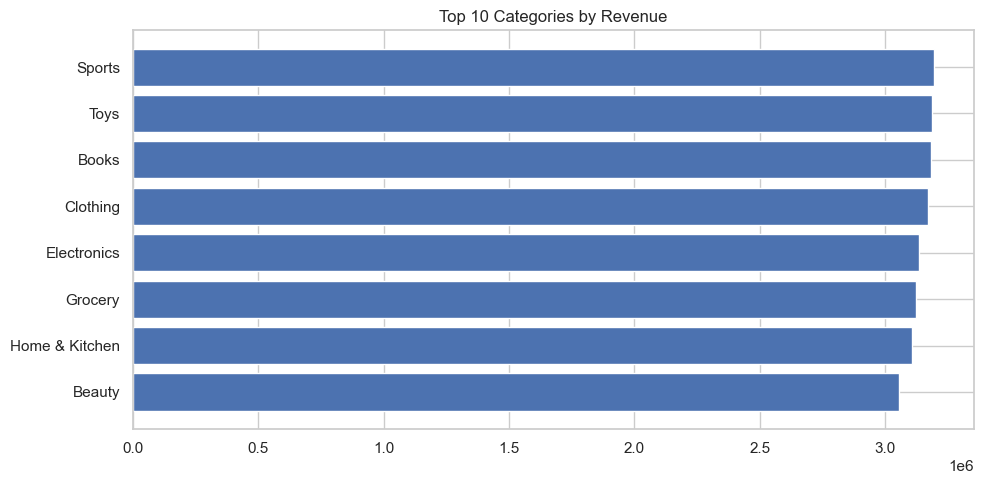

In [6]:

by_cat = (df.groupby(PROD_COL, as_index=False)
            .agg(Total_Revenue=(REV_COL,"sum"),
                 Transactions=(ID_COL,"count"),
                 Unique_Customers=(CUST_COL,"nunique"))
            .sort_values("Total_Revenue", ascending=False))
display(by_cat.head(10))

by_cat.to_csv(CAT_OUT, index=False)
print("Saved table →", CAT_OUT)

top10 = by_cat.head(10).iloc[::-1]
fig, ax = plt.subplots()
ax.barh(top10[PROD_COL], top10["Total_Revenue"])
titleify(ax, "Top 10 Categories by Revenue")
save_fig("../powerbi/top_categories.png")
plt.show()


### 3.3 Revenue by Country

,Country,Total_Revenue,Transactions,Unique_Customers
3,France,"2,545,739.19",4993,100
2,Canada,"2,544,335.12",5082,100
9,USA,"2,541,220.22",4979,100
7,Mexico,"2,534,475.67",5059,100
0,Australia,"2,514,911.65",4985,100
1,Brazil,"2,507,287.54",4948,100
5,India,"2,503,542.71",4996,100
4,Germany,"2,502,442.20",5047,100
6,Japan,"2,492,312.20",4960,100
8,UK,"2,471,723.15",4951,100


Saved table → ../data/region_revenue_rollup.csv
Saved chart → ../powerbi/top_countries.png


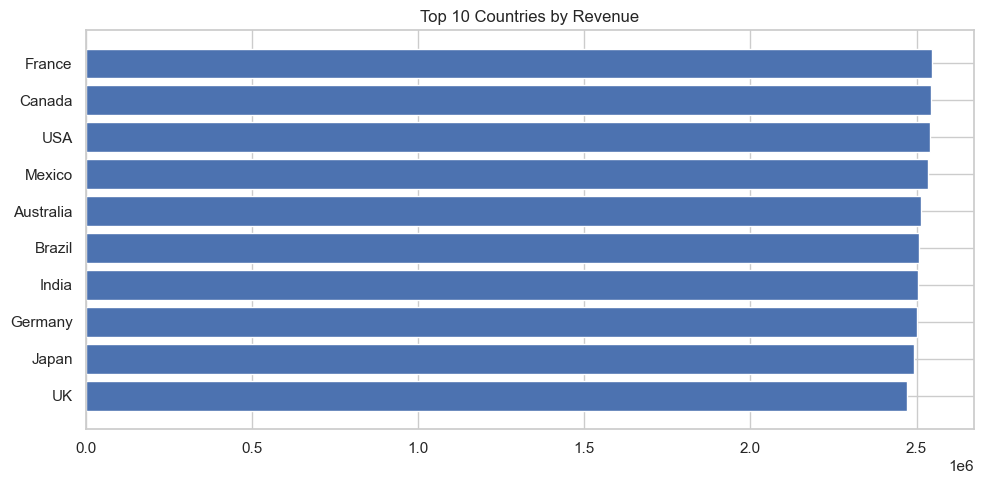

In [7]:

by_region = (df.groupby(REG_COL, as_index=False)
               .agg(Total_Revenue=(REV_COL,"sum"),
                    Transactions=(ID_COL,"count"),
                    Unique_Customers=(CUST_COL,"nunique"))
               .sort_values("Total_Revenue", ascending=False))
display(by_region.head(10))

by_region.to_csv(REGION_OUT, index=False)
print("Saved table →", REGION_OUT)

top10r = by_region.head(10).iloc[::-1]
fig, ax = plt.subplots()
ax.barh(top10r[REG_COL], top10r["Total_Revenue"])
titleify(ax, "Top 10 Countries by Revenue")
save_fig("../powerbi/top_countries.png")
plt.show()


### 3.4 Top Customers by Spend

,User_Name,Total_Spent,Transactions
94,Sophia Harris,"296,354.98",568
40,James Allen,"278,079.15",545
83,Olivia Hall,"277,302.09",534
33,Isabella Hall,"275,798.04",539
61,Noah Anderson,"274,347.15",545
22,Emma Clark,"274,313.60",546
2,Ava Clark,"273,776.79",517
13,Elijah Hall,"271,861.61",543
45,James Lewis,"271,007.68",543
3,Ava Hall,"268,756.73",517


Saved table → ../data/top_customers_rollup.csv
Saved chart → ../powerbi/top_customers.png


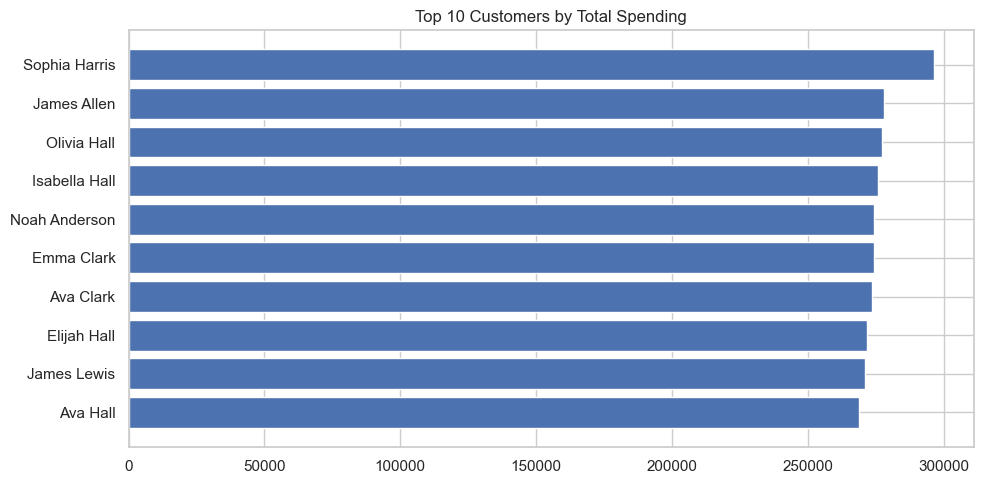

In [8]:

by_cust = (df.groupby(CUST_COL, as_index=False)
             .agg(Total_Spent=(REV_COL,"sum"),
                  Transactions=(ID_COL,"count"))
             .sort_values("Total_Spent", ascending=False))
display(by_cust.head(10))

by_cust.to_csv(TOPCUSTOMERS_OUT, index=False)
print("Saved table →", TOPCUSTOMERS_OUT)

top10c = by_cust.head(10).iloc[::-1]
fig, ax = plt.subplots()
ax.barh(top10c[CUST_COL], top10c["Total_Spent"])
titleify(ax, "Top 10 Customers by Total Spending")
save_fig("../powerbi/top_customers.png")
plt.show()


### 3.5 Repeat vs One‑Time Customers

,Customer_Type,Percentage
0,Repeat,100.00


Saved chart → ../powerbi/repeat_vs_onetime.png


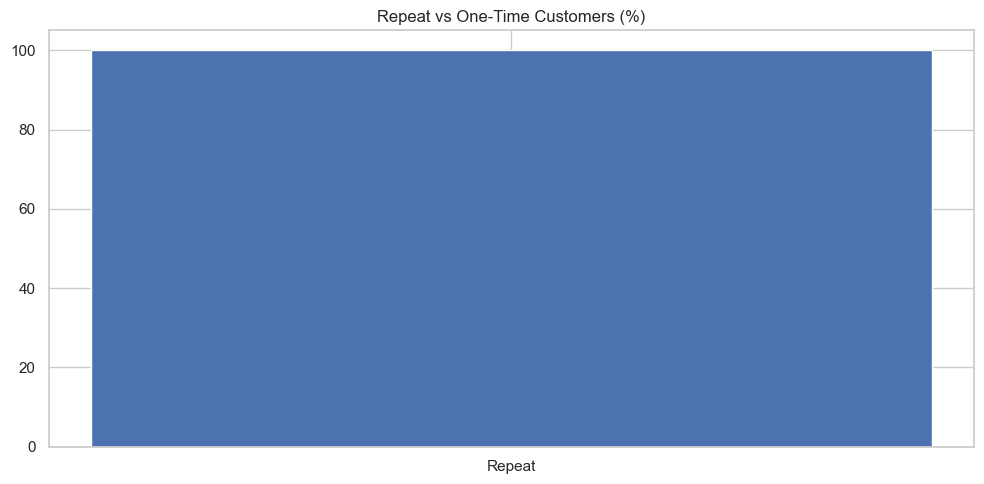

In [9]:

cust_counts = df.groupby(CUST_COL, as_index=False)[ID_COL].count().rename(columns={ID_COL:"Orders"})
repeat_rate = (cust_counts.assign(Customer_Type=np.where(cust_counts["Orders"]>1, "Repeat", "One-Time"))
                           ["Customer_Type"].value_counts(normalize=True)
                           .mul(100).rename_axis("Customer_Type").reset_index(name="Percentage"))
display(repeat_rate)

fig, ax = plt.subplots()
ax.bar(repeat_rate["Customer_Type"], repeat_rate["Percentage"])
titleify(ax, "Repeat vs One-Time Customers (%)")
save_fig("../powerbi/repeat_vs_onetime.png")
plt.show()


### 3.6 Revenue by Payment Method

,Payment_Method,Total_Revenue,Transactions
0,Cash on Delivery,"4,276,269.38",8434
5,UPI,"4,259,355.65",8477
2,Debit Card,"4,234,776.21",8355
4,PayPal,"4,173,529.85",8250
1,Credit Card,"4,150,547.15",8310
3,Net Banking,"4,063,511.41",8174


Saved table → ../data/payment_revenue_rollup.csv
Saved chart → ../powerbi/revenue_by_payment.png


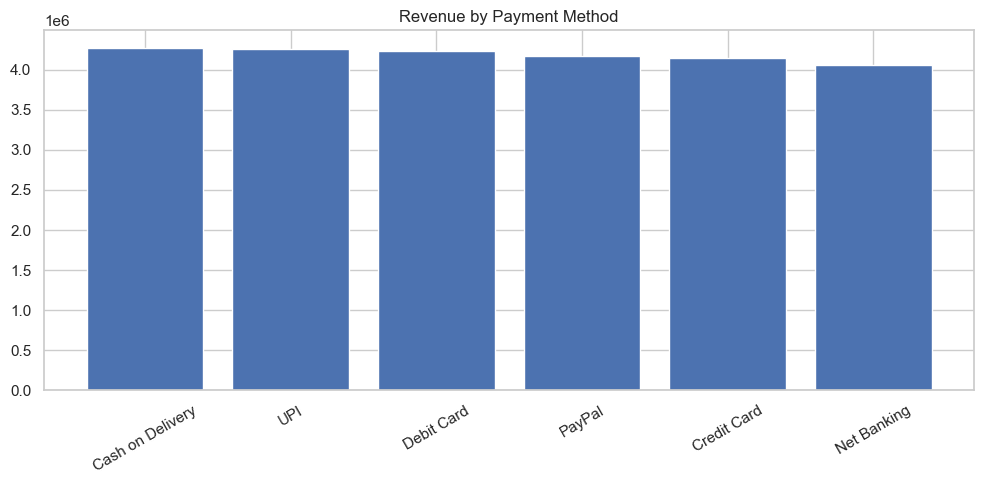

In [10]:

by_payment = (df.groupby(PAYMENT_COL, as_index=False)
                .agg(Total_Revenue=(REV_COL,"sum"),
                     Transactions=(ID_COL,"count"))
                .sort_values("Total_Revenue", ascending=False))
display(by_payment)

by_payment.to_csv(PAYMENT_OUT, index=False)
print("Saved table →", PAYMENT_OUT)

fig, ax = plt.subplots()
ax.bar(by_payment[PAYMENT_COL], by_payment["Total_Revenue"])
ax.tick_params(axis="x", rotation=30)
titleify(ax, "Revenue by Payment Method")
save_fig("../powerbi/revenue_by_payment.png")
plt.show()


## 4) Save Cleaned Dataset

In [11]:

df.to_csv(CLEAN_OUT, index=False)
print("Saved clean dataset →", CLEAN_OUT)


Saved clean dataset → ../data/ecommerce_transactions_clean.csv


## 5. Insights & Storytelling

### Key Insights

- **Monthly Revenue Trend**  
  Revenue shows steady performance with some seasonal variation. Minor dips suggest natural cycles, while overall stability indicates consistent demand.

- **Revenue by Payment Method**  
  Revenue is fairly evenly distributed across payment methods, though **Cash on Delivery (COD)** and **UPI** slightly lead. This may reflect regional trust or convenience factors.

- **Top Categories by Revenue**  
  **Sports, Toys, and Books** drive the most revenue, signaling strong demand in leisure and lifestyle-related products. Other categories like Beauty and Electronics remain competitive.

- **Top Countries by Revenue**  
  **France, Canada, and USA** lead in total revenue, followed closely by Mexico and Australia. This indicates a diverse customer base across multiple regions.

- **Top Customers by Spending**  
  A small number of customers (e.g., Sophia Harris, James Allen) contribute disproportionately to revenue. This highlights the importance of high-value customers.

- **Repeat vs One-Time Customers**  
  The dataset shows an unusually high proportion of **repeat customers**, which could either reflect very strong loyalty or a dataset bias (worth flagging for deeper validation).

---

### Recommendations

1. **Strengthen Loyalty Programs**  
   Leverage the high repeat customer base with rewards or referral incentives to maximize lifetime value.

2. **Focus Marketing on Winning Categories**  
   Prioritize campaigns around **Sports, Toys, and Books**, as they are already top revenue drivers.

3. **Regional Strategy**  
   Double down on top-performing countries (France, Canada, USA) while investigating potential growth opportunities in mid-tier markets.

4. **Payment Method Optimization**  
   Investigate why COD is slightly ahead — trust factor? delivery issues? Offering small discounts for digital payments may boost adoption.

---

